In [1]:
import pandas as pd
from statsmodels.api import tsa
from statsmodels.tsa.statespace.sarimax import SARIMAX
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [2]:
wks_df = pd.read_pickle('data/LCL_unstack_wks.pkl')
wks_df.head()

tariff,Std,ToU
DateTime,,
2012-01-01,0.523669,0.528838
2012-01-08,0.540989,0.541720
2012-01-15,0.532780,0.526268
2012-01-22,0.550542,0.533956
2012-01-29,0.553962,0.503050


In [3]:
def decompose_DFs (df, mult_or_add, p):
    output = pd.DataFrame()
    for col in df.columns:
        name = col + '_Decomp'
        globals()[name] = tsa.seasonal_decompose(df[[col]], model = mult_or_add, period = p, extrapolate_trend=True) # extrapolate_trend = 'freq' to fill in nulls
        output[col + '_Trend'] = globals()[name].trend
        output[col + '_Seasonal'] = globals()[name].seasonal
        output[col + '_Residual'] = globals()[name].resid
    
    return output

In [4]:
# recall DF_dict
DF_dict = pd.read_pickle('data/DF_dict.pkl')

In [5]:
decomp_periods = [8760, 365, 52]
for i in range(len(DF_dict['DF'])):
    df = DF_dict['DF'][i]
    suf = DF_dict['period'][i]
    period = decomp_periods[i]
    globals()['decomps' + suf] = decompose_DFs(df, 'multiplicative', period)

For the ARIMA model, we will consider the weekly values as this has the least seasonality. The hourly and daily granularities will also likely exceed the computing resources available.

In [6]:
prds = ['Trend', 'Seasonal', 'Residual']

fig = make_subplots(rows=3, cols=1, subplot_titles=prds, shared_xaxes=False)

for i in range(len(prds)):
    prd = prds[i]
    df = decomps_wks

    fig.add_trace(                          # Plot standard tariff
        go.Line(
            x=df.index, y=df.iloc[:,i], 
            name = 'Standard', 
            line_color = '#F2A74B',
            legendgroup = prd
            ),
        row = i+1,
        col = 1,
    )

    fig.add_trace(                          # Plot variable tariff
        go.Line(
            x=df.index, y=df.iloc[:,i+3], 
            name = 'Variable',
            line_color = '#415885',
            legendgroup = prd
            ),
        row = i+1,
        col = 1
    )

    fig.update_xaxes(title_text='Date-Time', row=i+1, col=1)
    fig.update_yaxes(title_text='Multiplier', row=i+1, col=1)

    fig.update_layout(
        legend_title = "Tariff", 
        title = "Seasonal Decomposition of Weekly Average Power Consumption",
        legend_tracegroupgap=350,
        height= 1200
    )

fig.show()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




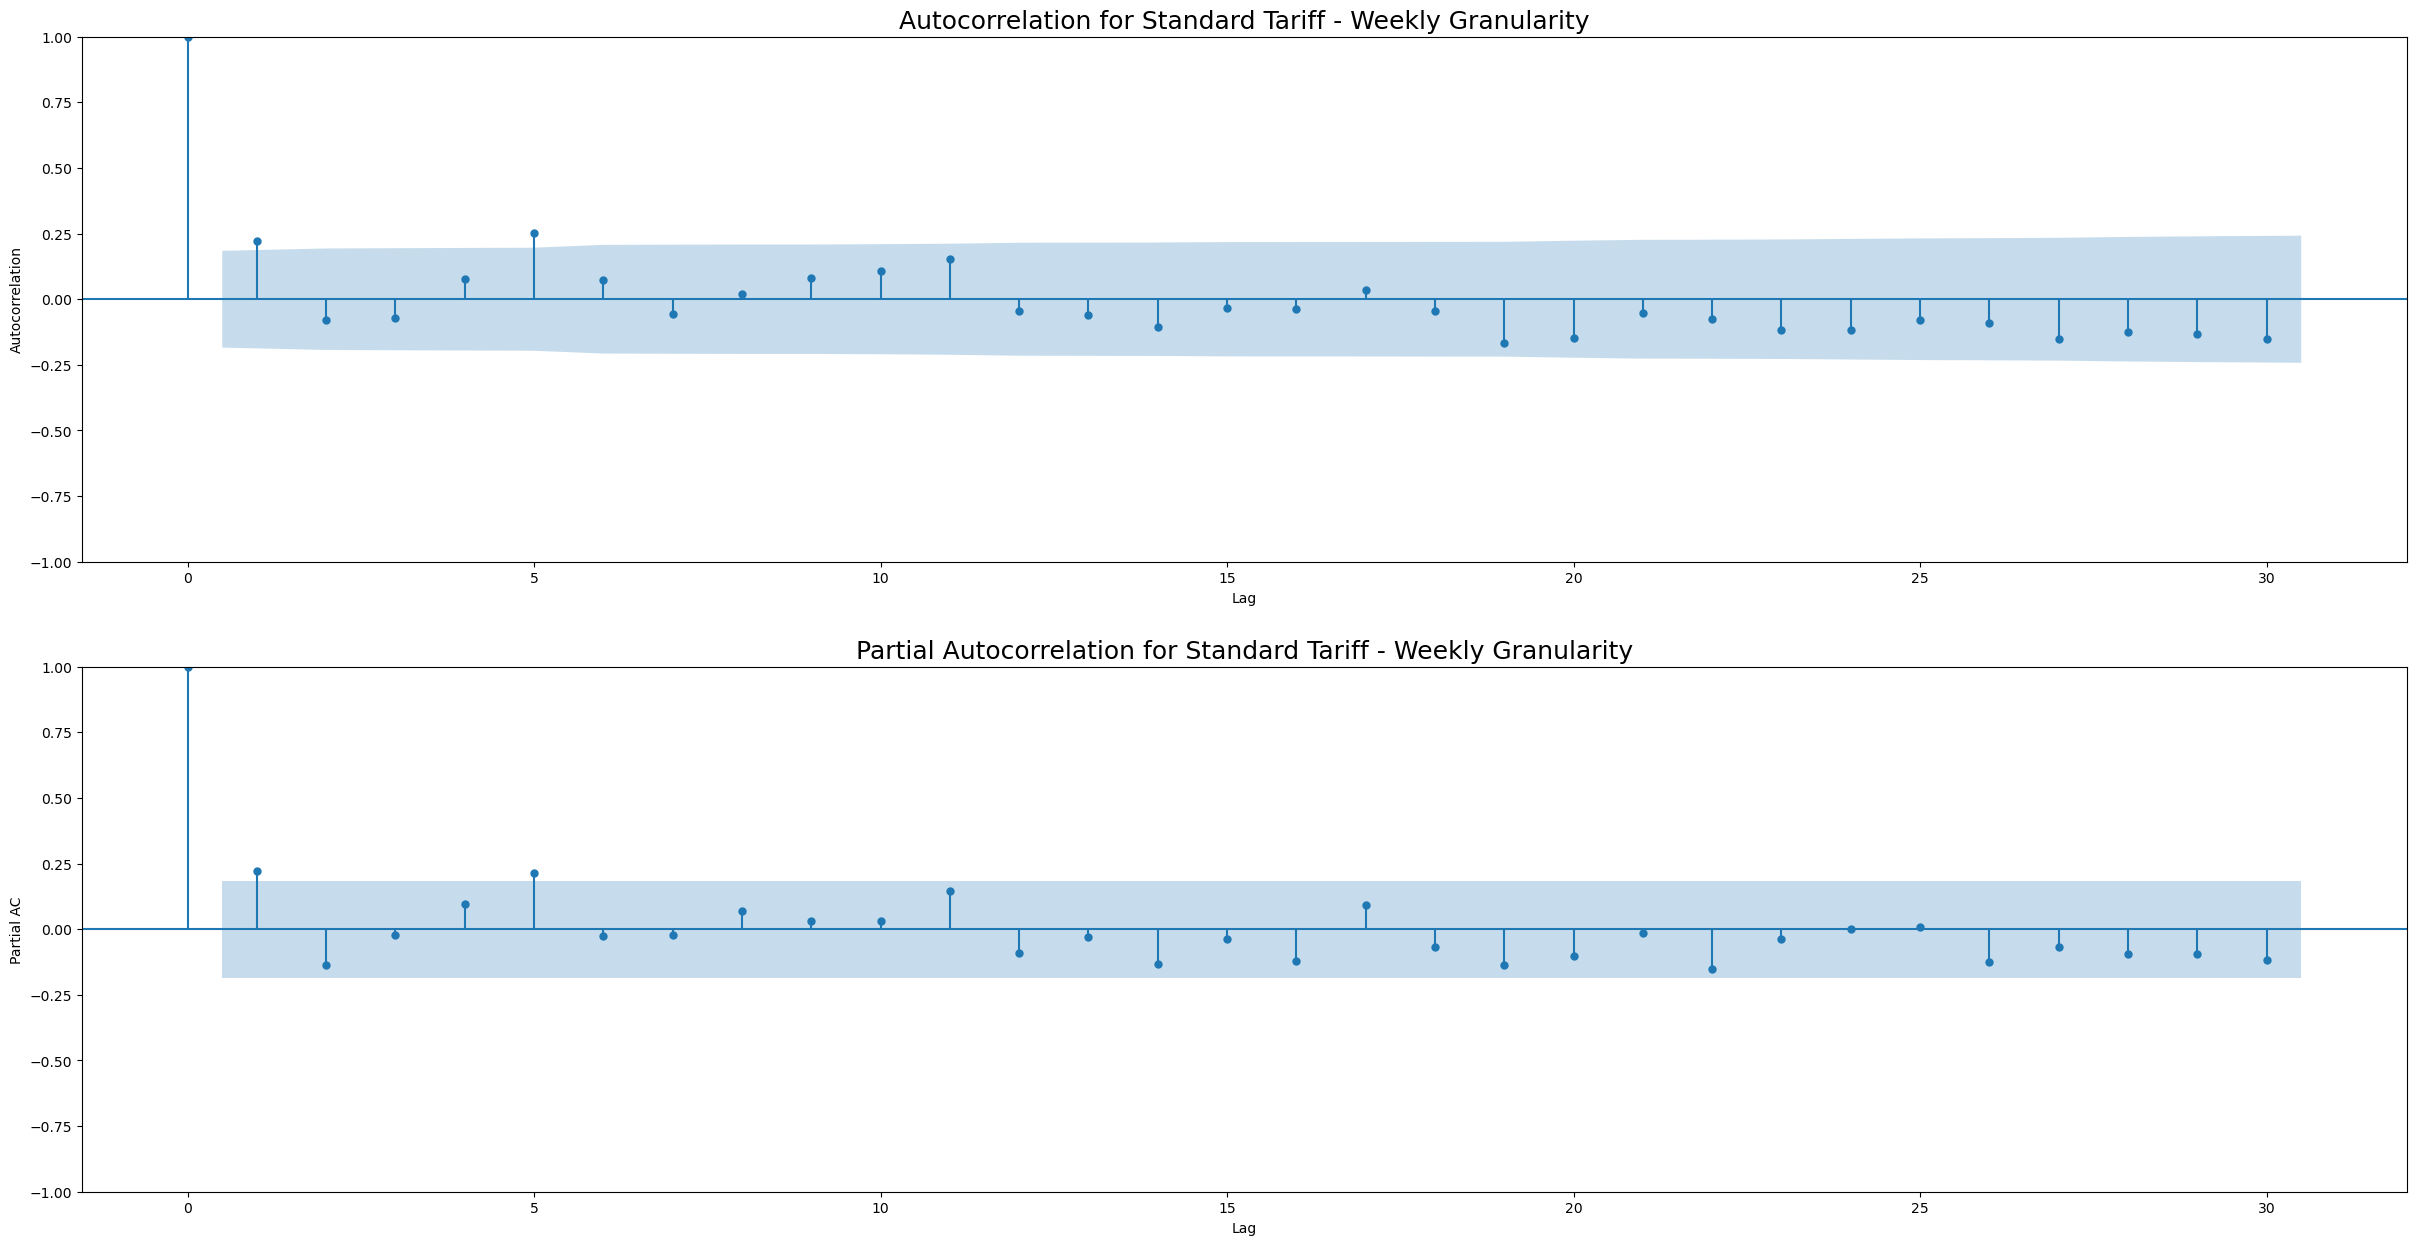

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(1).dropna(), lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(1).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

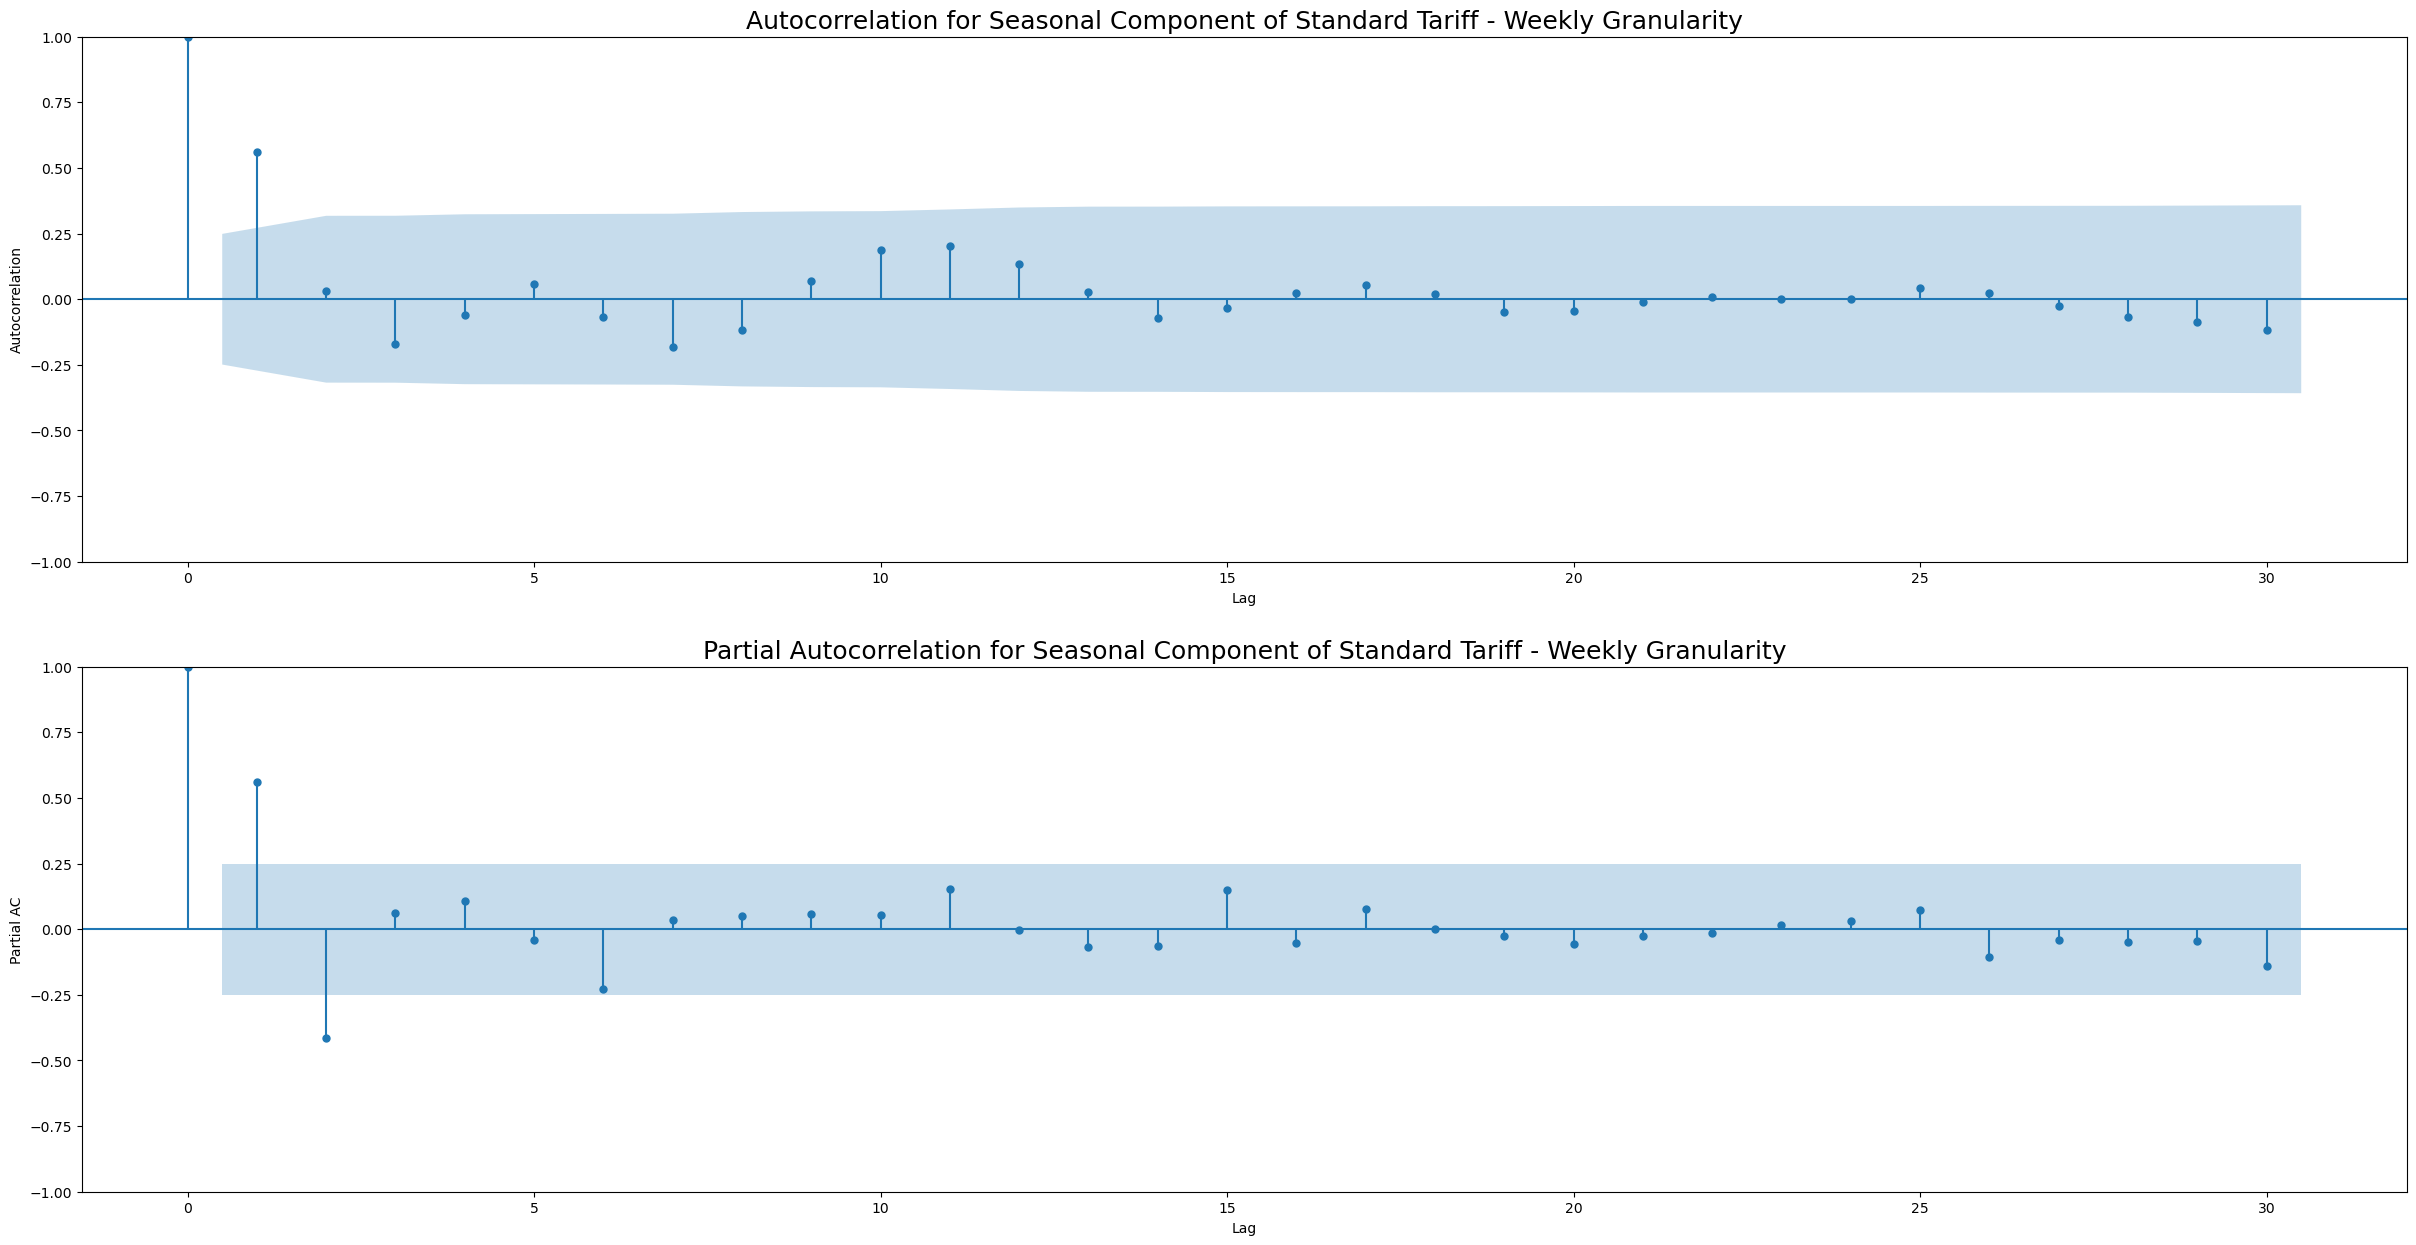

In [8]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

In [10]:
Std_test = wks_df['Std'].tail(round(0.2*wks_df["Std"].count()))
Std_train = wks_df['Std'].loc[wks_df.index < Std_test.index[0]]

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_Std = SARIMAX(Std_train, order=(5, 1, 5), seasonal_order = (1,1,2,52), trend="n")
SARIMA_Std = SARIMA_Std.fit()

SARIMA_Std.summary()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                     Std   No. Observations:                   91
Model:             SARIMAX(5, 1, 5)x(1, 1, [1, 2], 52)   Log Likelihood                  80.482
Date:                                 Mon, 31 Oct 2022   AIC                           -130.964
Time:                                         20:13:37   BIC                           -106.400
Sample:                                     01-01-2012   HQIC                          -122.225
                                          - 09-22-2013                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.003      0.146      0.884      -0.005       0.005
ar.L1          0.4600      1.514      0.304      0.761      -2.508       3.427
ar.L2         -0.4819      2.181     -0.221      0.825      -4.756       3.793
ar.L3         -0.0977      1.808     -0.054      0.957      -3.642       3.447
ar.L4          0.3882      1.735      0.224      0.823      -3.012       3.789
ar.L5         -0.3795      0.629     -0.603      0.546      -1.613       0.854
ma.L1         -0.5102      1.325     -0.385      0.700      -3.107       2.086
ma.L2          0.0517      2.276      0.023      0.982      -4.409       4.512
ma.L3         -0.4753      1.358     -0.350      0.726      -3.137       2.187
ma.L4         -0.3275      1.824     -0.180      0.858      -3.903       3.248
ma.L5          0.3537      1.451      0.244      0.807      -2.489       3.197
ar.S.L52       0.0490      1.962      0.025      0.980      -3.796       3.894
ma.S.L52       0.0231     11.678      0.002      0.998     -22.866      22.913
ma.S.L104     -0.0025    158.982  -1.58e-05      1.000    -311.602     311.596
sigma2         0.0007      0.001      0.623      0.533      -0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.27
Prob(Q):                              0.68   Prob(JB):                         0.12
Heteroskedasticity (H):               0.06   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+18. Standard errors may be unstable.
"""

In [29]:
predictions = SARIMA_Std.predict(start=0, end=len(Std_train)+len(Std_test)-1).shift(-1).dropna()

In [30]:
fig = go.Figure()
fig.add_trace(go.Line(x=Std_train.index, y=Std_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=Std_test.index, y=Std_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=predictions.index, y=predictions, mode='lines', name="Predictions"))

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




---

### Variable Tariff

In [14]:
ToU_test = wks_df['ToU'].tail(round(0.2*wks_df["ToU"].count()))
ToU_train = wks_df['ToU'].loc[wks_df.index < ToU_test.index[0]]

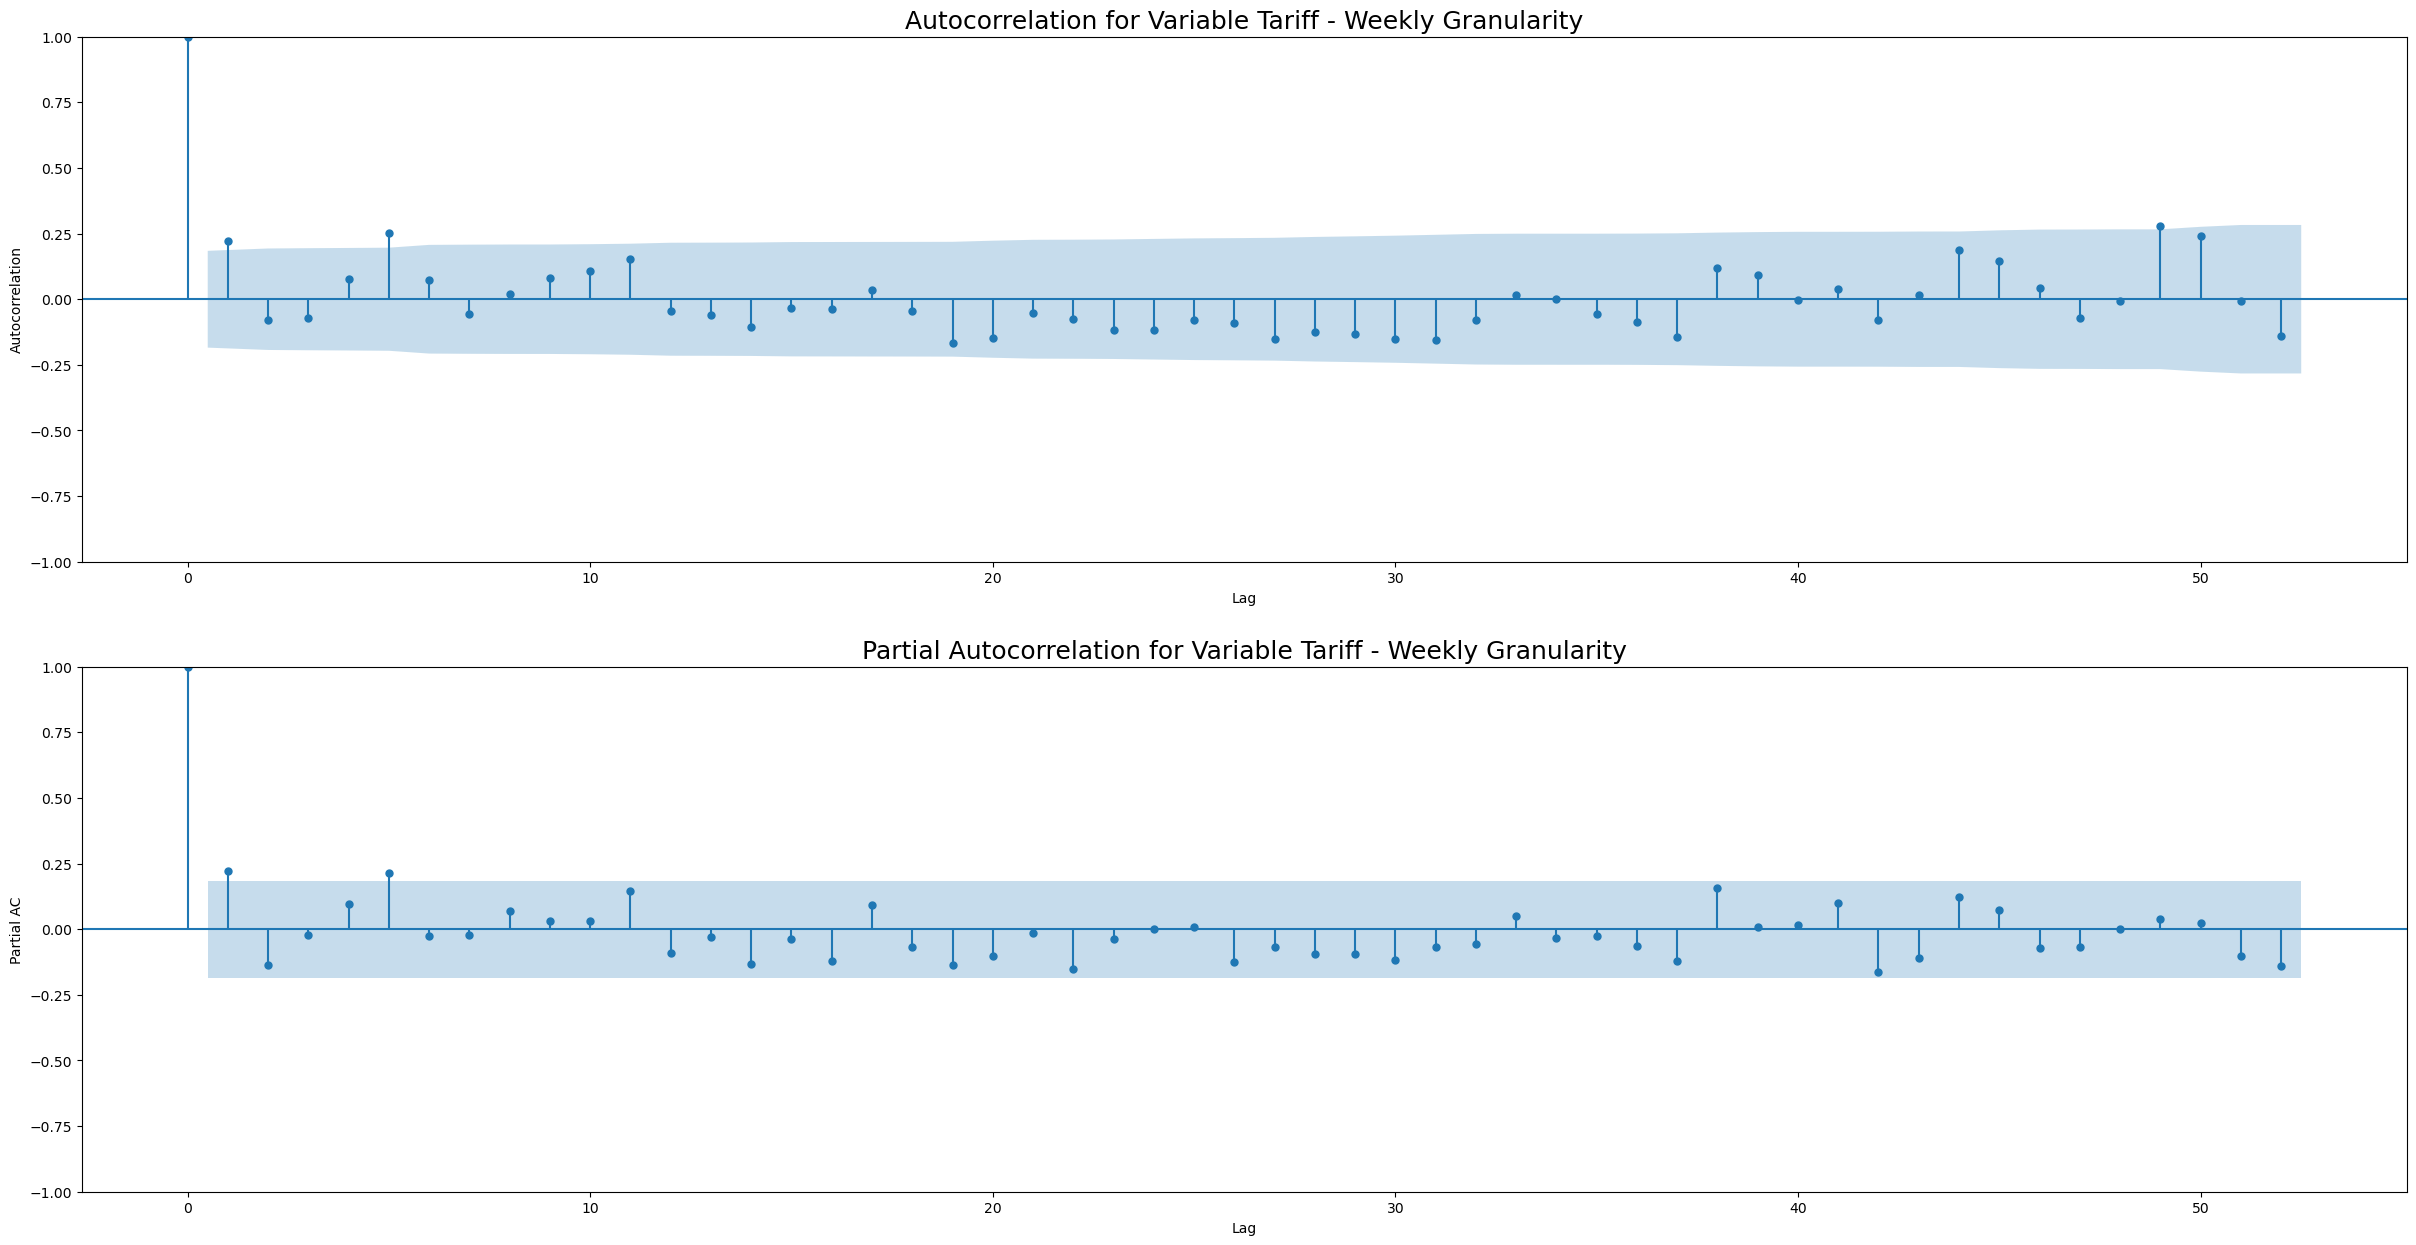

In [15]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(1).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(1).dropna(), lags=52, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

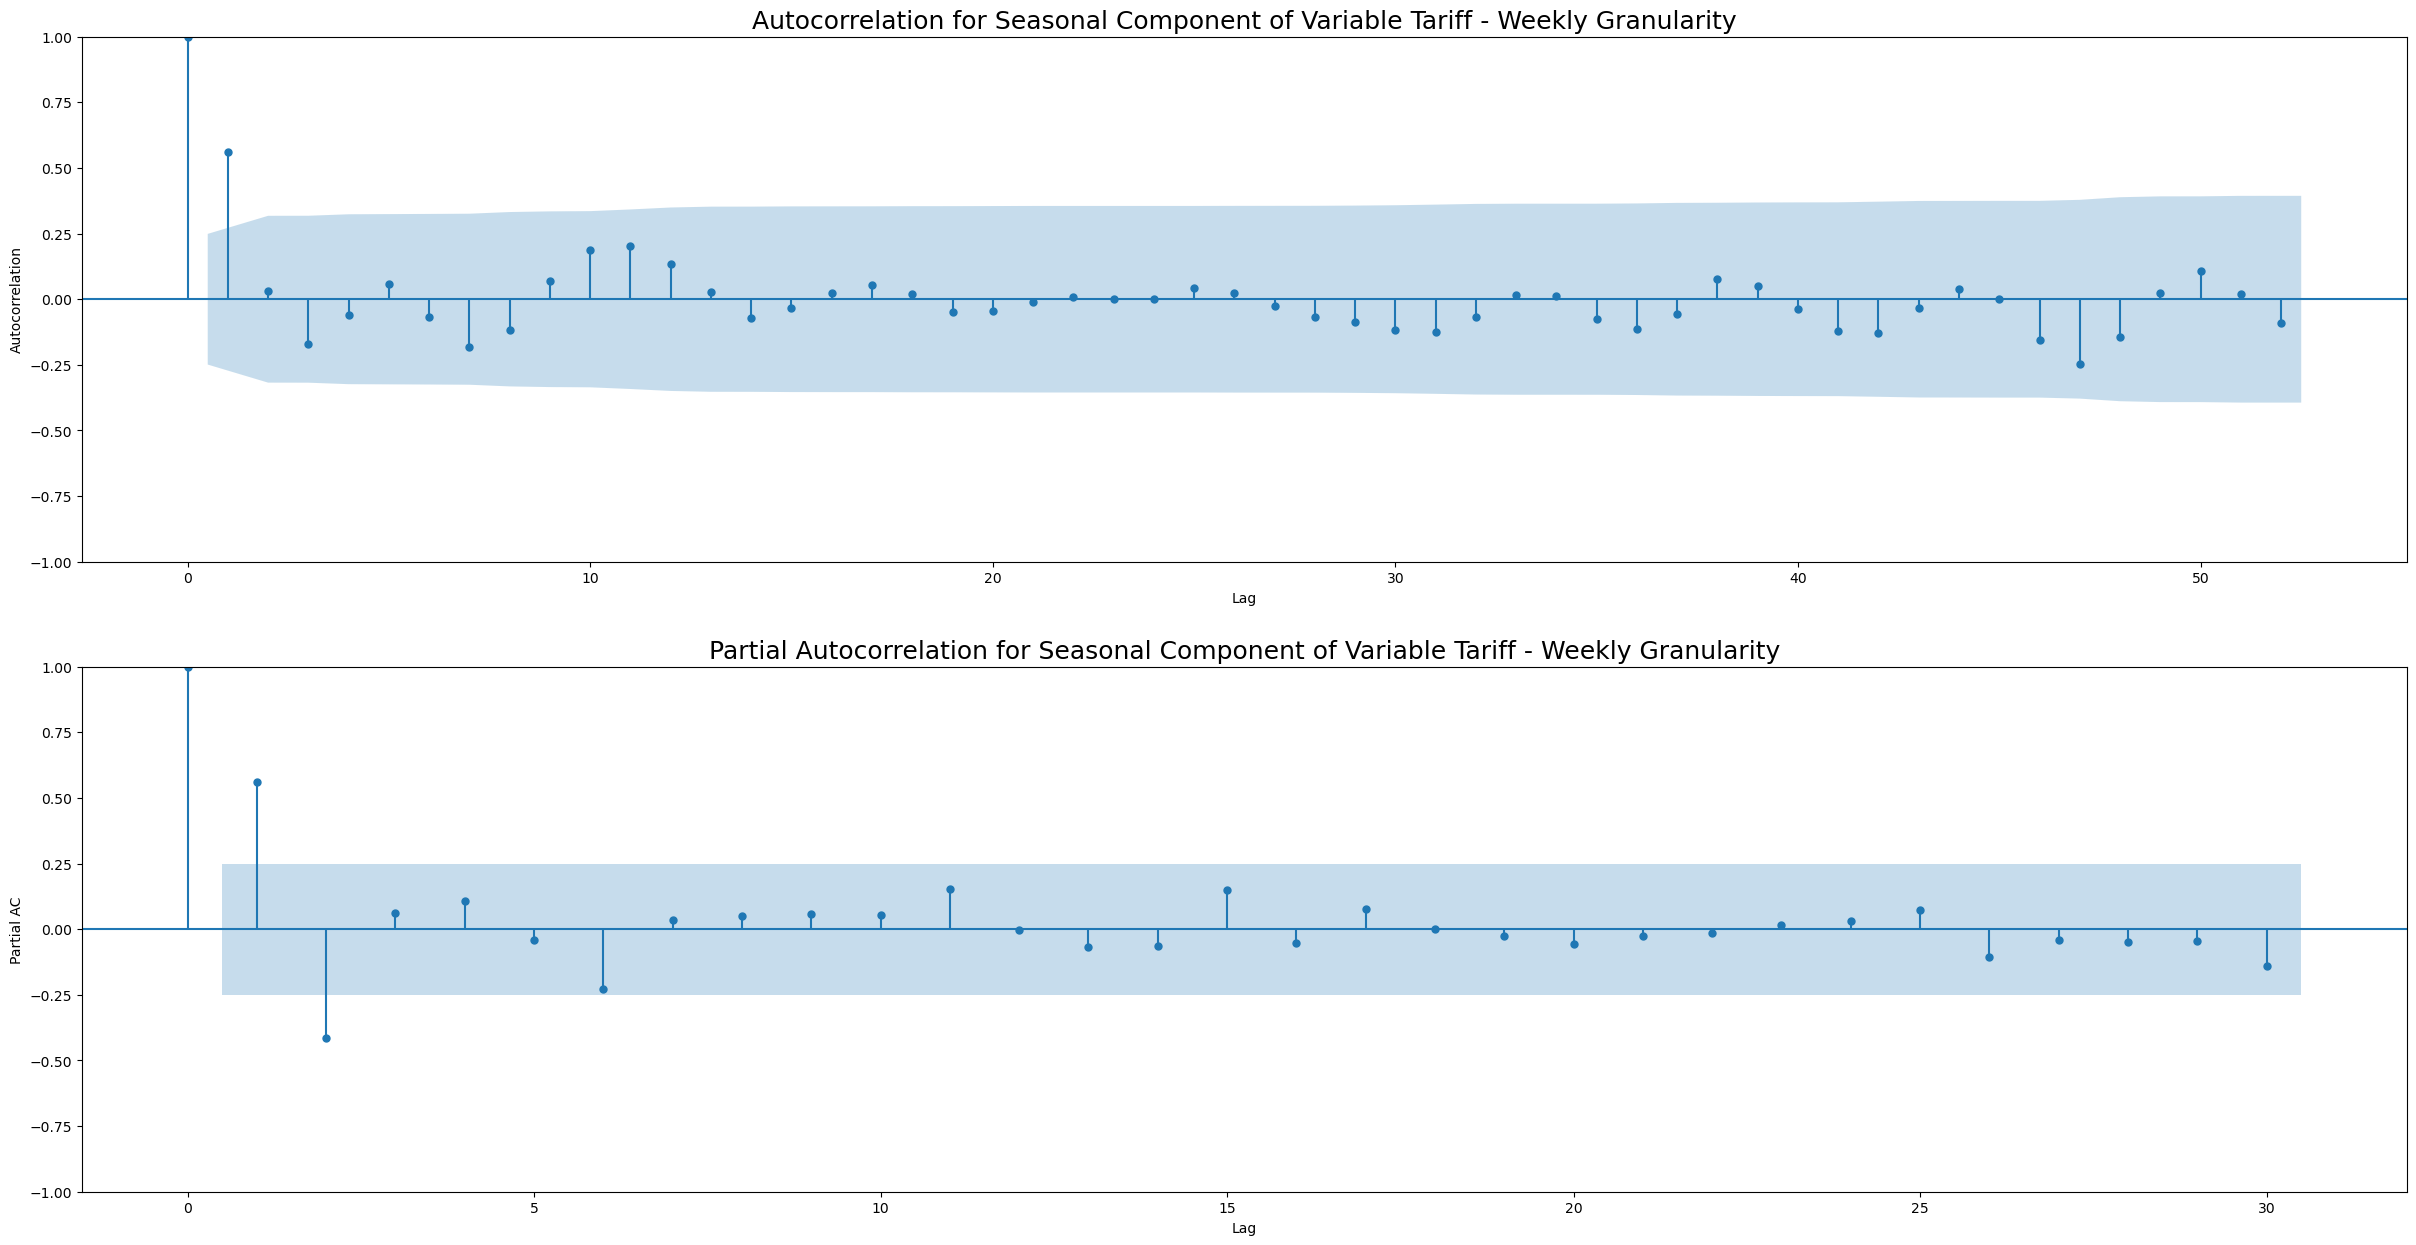

In [16]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(52).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_ToU = SARIMAX(ToU_train, order=(5, 1, 5), seasonal_order = (2,1,1,52)) # why does no trend make it better?
SARIMA_ToU = SARIMA_ToU.fit()

SARIMA_ToU.summary()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  ToU   No. Observations:                   91
Model:             SARIMAX(5, 1, 5)x(2, 1, [1], 52)   Log Likelihood                  81.277
Date:                              Mon, 31 Oct 2022   AIC                           -134.555
Time:                                      20:06:37   BIC                           -111.629
Sample:                                  01-01-2012   HQIC                          -126.398
                                       - 09-22-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2062     66.344     -0.003      0.998    -130.238     129.826
ar.L2         -0.3478     31.637     -0.011      0.991     -62.356      61.660
ar.L3         -0.0075     31.377     -0.000      1.000     -61.505      61.490
ar.L4          0.1569      8.199      0.019      0.985     -15.913      16.226
ar.L5         -0.0401      7.603     -0.005      0.996     -14.942      14.862
ma.L1          0.0406     66.489      0.001      1.000    -130.275     130.356
ma.L2         -0.1882     20.822     -0.009      0.993     -40.998      40.621
ma.L3         -0.5271      7.172     -0.073      0.941     -14.584      13.530
ma.L4         -0.3672     37.648     -0.010      0.992     -74.156      73.422
ma.L5          0.1397     33.628      0.004      0.997     -65.770      66.049
ar.S.L52   -7.037e-06     48.053  -1.46e-07      1.000     -94.182      94.182
ar.S.L104   2.995e-06      0.007      0.000      1.000      -0.014       0.014
ma.S.L52       0.0001     48.053      3e-06      1.000     -94.183      94.183
sigma2         0.0008      0.000      2.676      0.007       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 9.28
Prob(Q):                              0.67   Prob(JB):                         0.01
Heteroskedasticity (H):               0.09   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.21e+24. Standard errors may be unstable.
"""

In [18]:
ToU_pred = SARIMA_ToU.predict(start=wks_df.index[0], end = wks_df.index[wks_df.shape[0]-1])

ToU_pred_train = SARIMA_ToU.predict(ToU_train.index[0], end=ToU_train.index[len(ToU_train)-1]).shift(-1).dropna()
ToU_pred_test = SARIMA_ToU.predict(ToU_test.index[0], end=ToU_test.index[len(ToU_test)-1]).shift(-1).dropna()

In [19]:
fig = go.Figure()
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_pred_test, mode='lines', name="Test Predictions"))
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_pred_train, mode='lines', name="Train Predictions"))
fig.show()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [21]:
mean_absolute_percentage_error(ToU_test.head(-1),ToU_pred_test)

0.07307066004748869

In [111]:
mean_absolute_percentage_error(ToU_train.head(-1),ToU_pred_train)

0.022430505356494237

In [95]:
mean_absolute_error(ToU_train,ToU_pred_train)

0.02634650950011587

In [105]:
ToU_train

DateTime
2012-01-01    0.528838
2012-01-08    0.541720
2012-01-15    0.526268
2012-01-22    0.533956
2012-01-29    0.503050
                ...   
2013-08-25    0.318734
2013-09-01    0.315702
2013-09-08    0.327752
2013-09-15    0.353847
2013-09-22    0.354097
Freq: W-SUN, Name: ToU, Length: 91, dtype: float32